#### DNN 기반 이진분류 모델 구현
- 사용되는 데이터셋 : iris.csv
- feature : 3개
- target : 1개 Setosa와 나머지
- 학습방법 : 지도학습 -> 분류 > 이진분류
- 알고리즘 : 인공신경망(ANN) -> 심층(은닉층) 신경망 -> MLP(층이여러개), DNN(은닉층이 많은 구성) 
- FramWork : Pytorch

In [90]:
# 모듈 로딩
# 모델관련 모듈
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
from torchmetrics.classification import F1Score, BinaryF1Score
from torchmetrics.classification import F1Score, BinaryF1Score, BinaryAccuracy
from torchmetrics.classification import BinaryConfusionMatrix
from torchinfo import summary

# 데이터 전처리 및 시각화 모듈
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split

In [91]:
# 활용 패키지 버전 체크
def versioncheck():
    print(f' torch  {torch.__version__}')
    print(f' pandas  {pd.__version__}')

versioncheck()

 torch  2.4.1
 pandas  2.0.3


In [92]:
DATA_FILE = r'C:\Users\zizonkjs\머신러닝,딥러닝\data\iris.csv'
irisdf=pd.read_csv(DATA_FILE)
irisdf

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


In [93]:
### 타겟 변경 => 정수화, 클래스 3개 => 2개
irisdf['variety'].unique()
irisdf['variety'] == 'Setosa'

0       True
1       True
2       True
3       True
4       True
       ...  
145    False
146    False
147    False
148    False
149    False
Name: variety, Length: 150, dtype: bool

In [94]:
irisdf['variety']=(irisdf['variety'] == 'Setosa')
irisdf['variety']=irisdf['variety'].astype('int')
irisdf['variety']
irisdf

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0
146,6.3,2.5,5.0,1.9,0
147,6.5,3.0,5.2,2.0,0
148,6.2,3.4,5.4,2.3,0


[2] - 모델 클레스 설계 및 정의 - <hr>
어떤 클래스를 만들까? 고려
클래스 목적 : iris.DataSet 학습 후 추론
클래스 이름 : IrisBCFModel
부모 클래스 : nn.Module
매개 변수   : 층별 입출력 갯수 고정하기 때문에 필요 없음
클래스 속성 : featureDF, targetDF, n_rows, n_features
클래스 기능 : __init__() : 모델 구조, forward() : 순방향 학습 <= 오버라이딩(overriding) 상속관계일 때

클래스 구조  
    -입력층 : 피쳐 4개  퍼셉트론 : 50개(보통 입력 때 많이 주고 갈수록 줄임) (4,10)
    -은닉층 : 입력 10개     출력 5개   (10,5)
    -출력층 : 입력5개      타겟(이진분류) 1개    (5,1)  
  
-손실 함수/ 활성화 함수
    *클래스 형태 ==> nn.MESLoss, nn.ReLU ==> __init__() 메서드에 사용
    *함수 형태 ==> torch.nn.functional => forward()메서드에 사용

In [95]:
class IrisBFCModel(nn.Module):

    # 모델 구조 구성 및 인스턴스 생성 메서드
    def __init__(self):
        super().__init__()

        self.in_layer=nn.Linear(4, 10)
        self.hidden_layer=nn.Linear(10, 5)
        self.out_layer=nn.Linear(5, 1)
    
    # 순방향 학습 진행 메서드
    def forward(self, input_data):
        # 입력층
        y=self.in_layer(input_data) # f1w1+f2w2+f3w3+b 요런 식이 10개(숫자10개)
        y=F.relu(y)                   # 범위 0이상
        
        # 은닉층 : 10개의 숫자 받아오기
        y=self.hidden_layer(y)
        y=F.relu(y)

        # 출력층 : 5개의 숫자 값 => sigmoid 이진분류
        return F.sigmoid(self.out_layer(y))

In [96]:
# 모델 인스턴스 생성
model = IrisBFCModel()
print(model)


IrisBFCModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (hidden_layer): Linear(in_features=10, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=1, bias=True)
)


In [97]:
summary(model)

Layer (type:depth-idx)                   Param #
IrisBFCModel                             --
├─Linear: 1-1                            50
├─Linear: 1-2                            55
├─Linear: 1-3                            6
Total params: 111
Trainable params: 111
Non-trainable params: 0

[3] 데이터셋 클래스 설계 및 정의 <hr>
- 데이터셋 : iris.csv
- 피쳐개수 : 3개
- 타겟개수 : 1개
- 클래스이름 : IrisDataSet
- 부모클래스 : utils.data.DataSet
- 속성__필드 : featureDF, targetDF, n_rows, n_featrues  
- 필수 메서드:   
    *__init__(self) : 데이터셋 저장 및 전처리, 개발자가 필요한 속성 설정  
    *__len__(self) : 데이터의 개수 반환  
    *__getItem__(self, index) : 특정 인덱스의 피쳐와 타겟 반환

In [98]:
class IrisDataset(Dataset):

    def __init__(self, featureDF, targetDF):
        self.featureDF=featureDF
        self.targetDF=targetDF
        self.n_rows=featureDF.shape[0]
        self.n_features=featureDF.shape[1]
        

    def __len__(self):
        return self.n_rows

    def __getitem__(self, index):
        # 텐서화
        featureTS=torch.FloatTensor(self.featureDF.iloc[index].values)
        targetTS=torch.FloatTensor(self.targetDF.iloc[index].values)
        return featureTS, targetTS

In [99]:
# [테스트] 데이터셋 인스턴스 생성
featureDF = irisdf[irisdf.columns[:-1]] # 2D (150,3)
targetDF = irisdf[irisdf.columns[-1:]] # 1D(150,1)


irisDS=IrisDataset(featureDF,targetDF)

# 데이터로더 인스턴스 생성
irisDL = DataLoader(irisDS, batch_size=1)
for feature, label in irisDL:
    print(feature.shape, label.shape, feature, label)
    break

torch.Size([1, 4]) torch.Size([1, 1]) tensor([[5.1000, 3.5000, 1.4000, 0.2000]]) tensor([[1.]])


[4] 학습 준비
- 학습 횟수 : EPOCH ( 처음부터 끝까지 공부할 횟수 )
- 배치 크기 : BATCH_SIZE(학습량)
- 위치 지정 : DEVICE (텐서 저장 및 실행 위치 GPU/CPU)
- 학 습 률  : 가중치와 절편 업데이트 시 경사하강법으로 업데이트 간격 설정 0.001~0.1

In [100]:
# 학습 진행 관련 설정 값
EPOCH = 1000
BATCH_SIZE = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001

- 인스턴스 : 모델, 데이터 셋, 최적화 (, 성능지표) 

In [101]:
# 모델 인스턴스
# 학습용, 검증용, 테스트용 데이터 분리
model = IrisBFCModel()

# 학습용, 검증용, 테스트용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1)
print(f'{X_train.shape} {X_test.shape} {X_val.shape}')
print(f'{y_train.shape} {y_test.shape} {y_val.shape}')

# 학습용, 검증용, 테스트용 데이터셋 생성
trainDS = IrisDataset(X_train, y_train)
testDS = IrisDataset(X_test, y_test)
valDS = IrisDataset(X_val, y_val)

# 학습용 데이터 로더 인스턴스
trainDL=DataLoader(trainDS, batch_size=BATCH_SIZE)

# 최적화

(84, 4) (38, 4) (28, 4)
(84, 1) (38, 1) (28, 1)


- 최적화 & 손실함수 인스턴스 생성하기

In [102]:

# 최적화 인스턴스 => w, b model.parameter 전달
optimizer=optim.Adam(model.parameters(), lr=LR)


# 바이너리용 손실함수 인스턴스 => 분류
# 예측값을 확률값으로 전달함 ==> sigmoid() AF 처리 후 전달
reqLoss=nn.BCELoss()

[5] 학습진행

In [103]:
len(trainDL), trainDL.__len__()

(9, 9)

In [104]:
# 학습의 효과 확인 손실값과 성능평가값 저장 필요
LOSS_HISTORY, SCORE_HISTORY=[[],[]], [[],[]]
CNT = len(trainDL)
# 학습 모드로 모델 설정
model.train()

for epoch in range(EPOCH):

    # 학습 모드로 모델 설정
    model.train()

    # 배치크기만큼 데이터 로딩해서 학습 진행
    loss_total, score_total = 0,0

    for featureTS, targetTS in trainDL:

        #학습 진행
        pre_y=model(featureTS)

        #손실 계산
        loss=reqLoss(pre_y, targetTS)
        loss_total += loss.item()


        #성능평가 계산
        score=F1Score(task='binary')(pre_y, targetTS)
        score_total += score.item()

        #최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 에폭당 검증 기능을 키겠다.
    # 모델 검증 모드 설정
    model.eval()
    with torch.no_grad():
        # 검증 데이터셋
        val_featureTS=torch.FloatTensor(valDS.featureDF.values)
        val_targetTS=torch.FloatTensor(valDS.targetDF.values)
        
        #평가
        pre_val=model(val_featureTS)

        #손실
        loss_val=reqLoss(pre_val, val_targetTS)

        # 성능평가
        score_val = F1Score(task='binary')(pre_val, val_targetTS)

    # 에폭당 손실값과 성능평가 값 저장
    LOSS_HISTORY[0].append(loss_total/BATCH_SIZE)
    SCORE_HISTORY[0].append(score_total/BATCH_SIZE)

    LOSS_HISTORY[1].append(loss_val)
    SCORE_HISTORY[1].append(score_val)

In [105]:
print(LOSS_HISTORY)
print(SCORE_HISTORY)

[[0.5790665090084076, 0.5719766557216645, 0.5671928405761719, 0.5617889583110809, 0.5576131999492645, 0.5551486611366272, 0.5535615146160126, 0.5519259631633758, 0.5500845968723297, 0.5480229020118713, 0.5457386910915375, 0.5432162940502167, 0.5403921484947205, 0.5371750593185425, 0.5335789561271668, 0.5296143352985382, 0.5252877712249756, 0.5207730174064636, 0.5161581158638, 0.5113394409418106, 0.5062530100345611, 0.5008264601230621, 0.4949576497077942, 0.4888882637023926, 0.48243283331394193, 0.475592640042305, 0.46847555637359617, 0.46104106307029724, 0.4533516108989716, 0.44539734721183777, 0.4372870445251465, 0.429028183221817, 0.4207125961780548, 0.4123462736606598, 0.40391654670238497, 0.3955904543399811, 0.3874120593070984, 0.37804520428180693, 0.3587935298681259, 0.3249774843454361, 0.2884886622428894, 0.2580803245306015, 0.2303916335105896, 0.20605612695217132, 0.1843385085463524, 0.16511245518922807, 0.14819472581148146, 0.13342342153191566, 0.12034820541739463, 0.1088063046

[6] 학습결과 시각화
- 학습과 검증의 Loss 변화, 성능 변화 체크

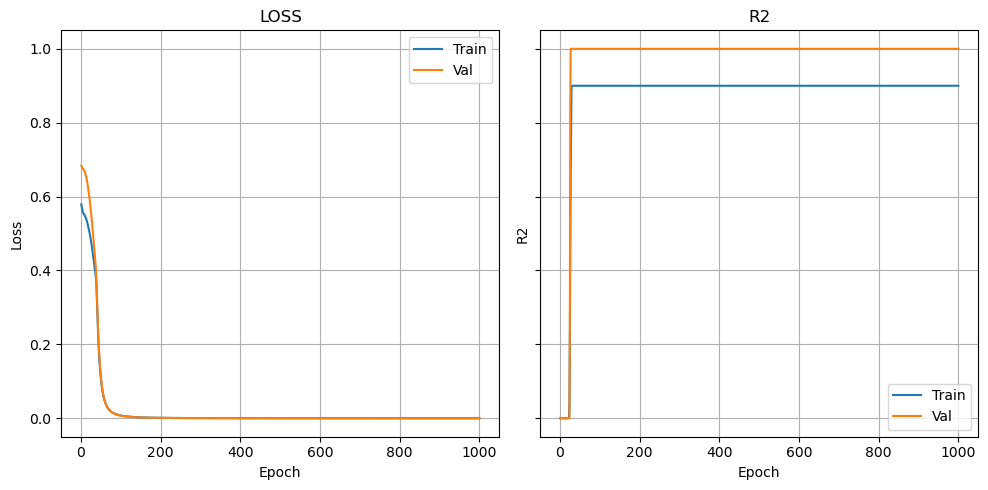

In [106]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

fg, axes=plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
axes[0].plot(range(1, EPOCH+1), LOSS_HISTORY[0][:EPOCH], label='Train')
axes[0].plot(range(1, EPOCH+1), LOSS_HISTORY[1][:EPOCH], label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("LOSS")

axes[1].plot(range(1, EPOCH+1), SCORE_HISTORY[0][:EPOCH], label='Train')
axes[1].plot(range(1, EPOCH+1), SCORE_HISTORY[1][:EPOCH], label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("R2")
axes[1].set_title("R2")
plt.tight_layout()
plt.show()

In [107]:
# 모델 검증 모드 설정
model.eval()
with torch.no_grad():
    # 검증 데이터셋
    test_featrueTS=torch.FloatTensor(testDS.featureDF.values).to(DEVICE)
    test_targetTS=torch.FloatTensor(testDS.targetDF.values).to(DEVICE)
    
    # 추론/평가
    pre_test=model(test_featrueTS)

    # 손실
    loss_test=reqLoss(pre_test, test_targetTS)
    # 성능평가
    #score_val=F1Score(task='binary')(pre_test, val_targetTS)
    score_Test=BinaryAccuracy()(pre_test, test_targetTS)
    
print(f'- [TEST] LOSS : {loss_test.item()} SCORE : {score_Test.item()}')

- [TEST] LOSS : 2.0808420231333002e-05 SCORE : 1.0
